# 体高推定のプログラム

# スキャン

### import

In [240]:
import numpy as np
import copy
import open3d as o3d
import math
import matplotlib.pyplot as plt

### パラメータの設定

In [241]:
#読み込むファイル名
filename = "nb269_0001_seg1.ply"

y_points = 1


In [242]:
#SCAN時に必要な配列
front_leg1 = np.zeros((1, 3), dtype=np.float32)
hind_leg1 = np.zeros((1, 3), dtype=np.float32)
body1 = np.zeros((1, 3), dtype=np.float32)
front_leg2 = np.zeros((1, 3), dtype=np.float32)
hind_leg2 = np.zeros((1, 3), dtype=np.float32)
body2 = np.zeros((1, 3), dtype=np.float32)

## ファイルの読み込み

In [273]:
pcd = o3d.io.read_point_cloud(filename)

PointCloud with 50811 points.

### numpy変換

In [244]:
points = np.asarray(pcd.points)

## RANSACで平面推定

In [245]:
def Plane_estimate():#平面推定
    o3d.visualization.draw_geometries([pcd])

    plane_model, inliers = pcd.segment_plane(distance_threshold=0.02,
                                            ransac_n=4,
                                            num_iterations=10000)

    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    plane_cloud = pcd.select_by_index(inliers)
    plane_cloud.paint_uniform_color([1.0, 0, 0])
    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    o3d.visualization.draw_geometries([plane_cloud, outlier_cloud])

    return a,b,c,d,plane_cloud

In [246]:
a,b,c,d,plane_cloud = Plane_estimate()

Plane equation: -0.02x + 0.99y + 0.15z + 1.09 = 0


## RANSACで推定した平面とxz平面とのなす角度・交線のベクトルを計算

### なす角度の計算

In [247]:
def Plane_theta(a,b,c):#Plane_estimateで推定した平面とxz平面とのなす角を計算
    #cosの計算
    t = 1
    L = math.sqrt(a**2 + b**2 + c**2)
    cos = (b*t)/(L * math.sqrt(t ** 2))
    Theta = math.acos(cos)
    print(f"Theta:{Theta}")
    return Theta

In [248]:
theta = Plane_theta(a,b,c)

Theta:0.1558866735000698


### 交線のベクトルを計算

In [249]:
def Vector(a,c):#二平面のなす交線方向のベクトルを計算
    t = 1
    u = (-c*t,0,a*t)
    #正規化
    u = (u[0] / (math.sqrt(u[0]**2+u[1]**2+u[2]**2)),0,u[2] / (math.sqrt(u[0]**2+u[1]**2+u[2]**2)))
    return u

In [250]:
vector = Vector(a,c)

## 点群の重心を計算

In [251]:
cog = np.asarray(plane_cloud.points).mean(axis=0) * -1

## 点群の平行移動・回転

In [252]:
def Rotation(Theta,u,plane_cloud):#Plane_thetaで計算したxz平面とのなす角を用いて平行移動・回転
    mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
    pcd_t = copy.deepcopy(pcd)
    #平行移動
    pcd_r = pcd_t.translate(cog)
    o3d.visualization.draw_geometries([pcd,pcd_r,mesh,pcd_t])
    #回転
    R = pcd_r.get_rotation_matrix_from_axis_angle(np.array(u)*Theta)
    pcd_r = pcd_r.rotate(R, center=(0,0,0))
    

    o3d.visualization.draw_geometries([pcd,pcd_r,mesh,pcd_t])

    o3d.io.write_point_cloud("cowcow.ply", pcd_r)
    plane_model, inliers = pcd_r.segment_plane(distance_threshold=0.05,
                                                ransac_n=4,
                                                num_iterations=10000)

    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    outlier_cloud = pcd_r.select_by_index(inliers, invert=True)
    o3d.visualization.draw_geometries([outlier_cloud])
    return outlier_cloud,pcd_r

In [253]:
outlier_cloud, pcd_r = Rotation(theta,vector,plane_cloud) 

Plane equation: 0.00x + 1.00y + -0.00z + -0.00 = 0


## スキャン

In [254]:
def Scan(pcd_r):#輪切りにする
    bounding_polygon = np.array([
    [ 10.0, 0.0, 10.0 ],
    [ 10.0, 0.0, -10.0 ],
    [ -10.0, 0.0, -10.0 ],
    [ -10.0, 0.0, 10.0],
    ])

    vol = o3d.visualization.SelectionPolygonVolume()
    vol.orthogonal_axis = "Y"
    vol.axis_max = y_points*0.01
    vol.axis_min = (y_points-1)*0.01
    vol.bounding_polygon = o3d.utility.Vector3dVector(bounding_polygon)
    
    cropped_pcd = vol.crop_point_cloud(pcd_r)
    cropped_pcd.paint_uniform_color([1.0, 0, 0])
    return cropped_pcd

# 分類

## スキャンした部分をDBSCAN

In [255]:
def Leg(cropped_pcd,front_leg2,hind_leg2,body2):#足かどうかの判別を行う
    leg_judge = np.asarray(cropped_pcd.points)
    labels = np.array(cropped_pcd.cluster_dbscan(eps=0.1, min_points=10))
    #物体はひとつか？
    if len(leg_judge) == 0:
        max_label = 0
    else:
        max_label = labels.max()
    print(len(labels))
    print(f"point cloud has {max_label + 1} clusters")
    #二つ以上なので足と判断
    if max_label >= 1:
        #重心を計算
        juusin = leg_judge.mean(axis=0)
        #重心のx値より大きいものは前足と判断
        front_leg1 = np.zeros((len(np.append(leg_judge[leg_judge[:,0]>juusin[0]],front_leg2,axis=0)),3),dtype=np.float32)
        front_leg1 = np.append(leg_judge[leg_judge[:,0]>juusin[0]],front_leg2,axis=0)
        front_leg2 = np.zeros((len(front_leg1),3),dtype=np.float32)
        front_leg2 = front_leg1
        #重心のx値より小さいものは後ろ足と判断
        hind_leg1 = np.zeros((len(np.append(leg_judge[leg_judge[:,0]<juusin[0]],hind_leg2,axis=0)),3),dtype=np.float32)
        hind_leg1 = np.append(leg_judge[leg_judge[:,0]<juusin[0]],hind_leg2,axis=0)
        hind_leg2 = np.zeros((len(hind_leg1),3),dtype=np.float32)
        hind_leg2 = hind_leg1
    #ひとつなので胴体(+顔)と判断
    else:
        body1 = np.zeros((len(np.append(leg_judge,body2,axis=0)),3),dtype=np.float32)
        body1 = np.append(leg_judge,body2,axis=0)
        body2 = np.zeros((len(body1),3),dtype=np.float32)
        body2 = body1
    return labels, max_label, front_leg2, hind_leg2, body2

In [256]:
scan = Scan(pcd_r)
labels, max_label, front_leg, hind_leg, body= Leg(scan,front_leg2,hind_leg2,body2)
for y_points in range(2,130):
    scan = Scan(outlier_cloud)
    labels, max_label, front_leg, hind_leg, body = Leg(scan,front_leg,hind_leg,body)
print(body)

9000
point cloud has 1 clusters
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
0
point cloud has 1 clusters
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
0
point cloud has 1 clusters
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
0
point cloud has 1 clusters
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
0
point cloud has 1 clusters
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
0
point cloud has 1 clusters
34
point cloud has 1 clusters
86
point cloud has 2 clusters
77
point cloud has 3 clusters
116
point cloud has 3 clusters
112
point cloud has 3 clusters
104
point cloud has 3 clusters
95
point cloud has 3 clusters
87
point cloud has 3 clusters
98
point cloud has 3 clusters
92
point cloud has 4 clusters
90
point cloud has 4 clusters
81
point cloud has 3 clusters
81
point cloud has 4 clusters
79
point cloud has 4 clusters
90
point cloud has 3 clusters
83
point cloud has 3 clusters
95
point c

### y座標を無視してxz座標平面にプロットする

In [257]:
def Plot(cropped_pcd):#輪切りにした点をy座標を無視してxz座標平面にプロットする
    pcd_xz = np.asarray(cropped_pcd.points)
    print(pcd_xz)
    x = np.zeros((len(pcd_xz),1),dtype=np.float32)
    z = np.zeros((len(pcd_xz),1),dtype=np.float32)
    x = pcd_xz[:,0]
    z = pcd_xz[:,2]

    xz = np.zeros((len(pcd_xz),2),dtype=np.float32)
    xz[:,0] = x
    xz[:,1] = z

    # figureを生成する
    fig = plt.figure()
    # axをfigureに設定する
    ax = fig.add_subplot(1, 1, 1)   
    # axesに散布図を設定する
    ax.scatter(x, z, c='b')
    #凡例要素を表示
    ax.set_xlim(left=-3, right=3)  # x範囲
    ax.set_ylim(bottom=-3, top=3)  # y範囲
    ax.set_xlabel('X')  # x軸ラベル
    ax.set_ylabel('Z')  # y軸ラベル
    ax.set_title('y=0')  # グラフタイトル
    ax.legend(['x1, y1', 'x2, y2'])  # 凡例を表示
    # 表示する
    plt.show()

    return xz

### 前足の表示

PointCloud with 3623 points.
[[0.27970707 1.15230517 0.4598414 ]
 [0.03548096 1.15590667 0.50005264]
 [0.48589602 1.15911294 0.38941348]
 ...
 [0.35324625 0.07340231 0.34869516]
 [0.32264559 0.07060643 0.36173524]
 [0.         0.         0.        ]]


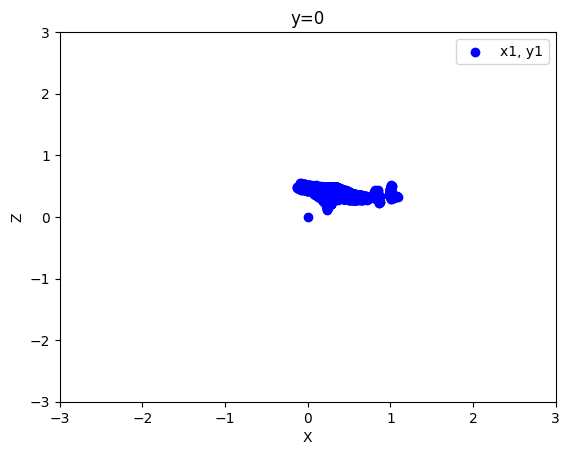

array([[0.27970707, 0.4598414 ],
       [0.03548096, 0.50005263],
       [0.48589602, 0.38941348],
       ...,
       [0.35324624, 0.34869516],
       [0.3226456 , 0.36173525],
       [0.        , 0.        ]], dtype=float32)

In [258]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
pcd_dv =o3d.geometry.PointCloud()
pcd_dv.points = o3d.utility.Vector3dVector(front_leg)
print(pcd_dv)
o3d.visualization.draw_geometries([pcd_dv,mesh])
Plot(pcd_dv)

## DBSCAN

In [259]:
def DBScan(pcd):#DBScanを行う
    labels = np.array(pcd.cluster_dbscan(eps=0.1, min_points=270))
    max_label = labels.max()
    print(len(labels))
    print(f"point cloud has {max_label + 1} clusters")
    seg = plt.get_cmap("tab20")(labels / max(max_label,1))
    seg[labels < 0] = 0
    #セグメンテーションの可視化
    pcd_seg =o3d.geometry.PointCloud()
    pcd_seg.points = o3d.utility.Vector3dVector(pcd.points)
    pcd_seg.colors = o3d.utility.Vector3dVector(seg[:, :3])
    return labels, max_label, pcd_seg

In [260]:
#さらに前足を精度高く検出
labels, max_label, pcd_seg = DBScan(pcd_dv)
points = np.asarray(pcd_dv.points)
o3d.visualization.draw_geometries([pcd_seg])


3623
point cloud has 1 clusters


## 分類した物体の重心をそれぞれ計算

In [261]:
def Devide(labels, points, d):#セグメンテーションを行う
    p = 0
    count = np.count_nonzero(labels == d)
    print(f"{d+1}番目の点群数:{count}")
    pcd_pt = np.zeros((count, 3), dtype=np.float32)
    pcd_cl = np.zeros((count, 3), dtype=np.float32)
    for k in range(len(labels)):#ここでラベルごとに点群を分けている
        if (labels[k] == d):
            pcd_pt[p] = points[k]
            p = p + 1
    #点群を統合している
    pcd_dv =o3d.geometry.PointCloud()
    pcd_dv.points = o3d.utility.Vector3dVector(pcd_pt)
    return pcd_dv, count

## 物体の点群の点数が最大のものを選択

In [262]:
foot_mean = 0
for d in range(0,max_label+1):
    pcd_dvd, count = Devide(labels,points,d)
    o3d.visualization.draw_geometries([pcd_dvd])
    devide_np = np.asarray(pcd_dvd.points)
    devide_mean = devide_np.mean(axis=0)
    bunrui = len(devide_np) #/ devide_mean[1]
    if bunrui > foot_mean:
        foot_mean = bunrui
        cluster_num = d
        pcd_foot = o3d.geometry.PointCloud()
        pcd_foot.points = pcd_dvd.points

1番目の点群数:3000


# 推定

## y座標を除去して平面にプロット

[[0.01716064 0.67421776 0.4907105 ]
 [0.18785566 0.67048621 0.47954741]
 [0.18188281 0.67100978 0.47080323]
 ...
 [0.32187337 0.07987729 0.35938698]
 [0.35324624 0.07340231 0.34869516]
 [0.3226456  0.07060643 0.36173525]]


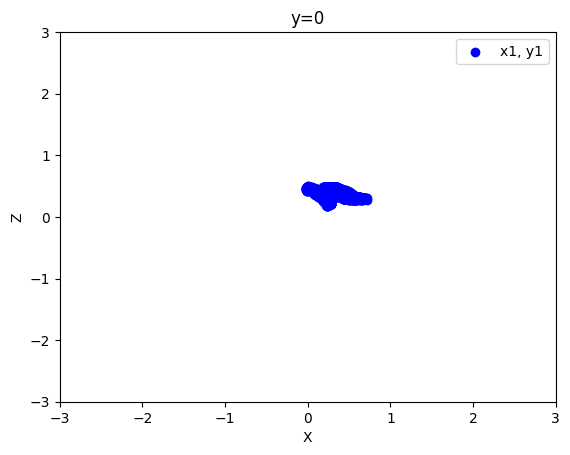

In [263]:
plot = Plot(pcd_foot)

## 重心をとる

In [264]:
mean = plot.mean(axis=0)

## 重心と点群との距離を計算し，最大のものを選択

In [265]:
hankei = np.zeros(len(plot),dtype=np.float32)

## 重心を中心，最大の距離を半径とする正六角形を作成

In [266]:
def Hexagon(xz,pcd):
    for k in range(0,len(xz)):
        hankei[k] = np.linalg.norm(mean-xz[k])
    index_hankei = hankei.argmax()
    max_hankei = xz[index_hankei]
    print(max_hankei)
    u = max_hankei - mean
    print(u)
    #回転
    ax = u[0]*math.cos(np.deg2rad(60)) - u[1]*math.sin(np.deg2rad(60)) + mean[0]
    az = u[0]*math.sin(np.deg2rad(60)) + u[1]*math.cos(np.deg2rad(60)) + mean[1]
    bx = u[0]*math.cos(np.deg2rad(120)) - u[1]*math.sin(np.deg2rad(120)) + mean[0]
    bz = u[0]*math.sin(np.deg2rad(120)) + u[1]*math.cos(np.deg2rad(120)) + mean[1]
    cx = u[0]*math.cos(np.deg2rad(180)) - u[1]*math.sin(np.deg2rad(180)) + mean[0]
    cz = u[0]*math.sin(np.deg2rad(180)) + u[1]*math.cos(np.deg2rad(180)) + mean[1]
    dx = u[0]*math.cos(np.deg2rad(240)) - u[1]*math.sin(np.deg2rad(240)) + mean[0]
    dz = u[0]*math.sin(np.deg2rad(240)) + u[1]*math.cos(np.deg2rad(240)) + mean[1]
    ex = u[0]*math.cos(np.deg2rad(300)) - u[1]*math.sin(np.deg2rad(300)) + mean[0]
    ez = u[0]*math.sin(np.deg2rad(300)) + u[1]*math.cos(np.deg2rad(300)) + mean[1]
    fx = u[0]*math.cos(np.deg2rad(360)) - u[1]*math.sin(np.deg2rad(360)) + mean[0]
    fz = u[0]*math.sin(np.deg2rad(360)) + u[1]*math.cos(np.deg2rad(360)) + mean[1]

    rokkaku = np.zeros((7,3),dtype=np.float32)
    rokkaku = [[ax,0,az],[bx,0,bz],[cx,0,cz],[dx,0,dz],[ex,0,ez],[fx,0,fz],[mean[0],0,mean[1]]]
    Rokkaku = o3d.geometry.PointCloud()
    Rokkaku.points = o3d.utility.Vector3dVector(rokkaku)

    return Rokkaku

## y軸方向に伸ばして六角柱を作る

In [288]:
def Rokkakuchu(rokkaku,pcd):
    rokkaku_np = np.zeros((7,3),dtype=np.float32)
    rokkaku_np = np.asarray(rokkaku.points)
    #meanを中心として正六角形を作る
    bounding_polygon = np.array([
    [ rokkaku_np[0,0],rokkaku_np[0,1],rokkaku_np[0,2]],
    [ rokkaku_np[1,0],rokkaku_np[1,1],rokkaku_np[1,2]],
    [ rokkaku_np[2,0],rokkaku_np[2,1],rokkaku_np[2,2]],
    [ rokkaku_np[3,0],rokkaku_np[3,1],rokkaku_np[3,2]],
    [ rokkaku_np[4,0],rokkaku_np[4,1],rokkaku_np[4,2]],
    [ rokkaku_np[5,0],rokkaku_np[5,1],rokkaku_np[5,2]],
    ])

    vol = o3d.visualization.SelectionPolygonVolume()
    vol.orthogonal_axis = "Y"
    vol.axis_max = 10
    vol.axis_min = -10
    vol.bounding_polygon = o3d.utility.Vector3dVector(bounding_polygon)
    
    taikou_pcd = vol.crop_point_cloud(pcd)
    taikou_pcd.paint_uniform_color([1.0, 0, 0])
    #pcd_y = pcd_r.translate([-0.01,0,-0.01])
    o3d.visualization.draw_geometries([taikou_pcd,pcd])

    return taikou_pcd

## 六角柱内の点群を全て選択

[0.71511537 0.27632442]
[ 0.3990303  -0.08659986]
[[ 0.5905979   0.          0.66519472]
 [ 0.1915676   0.          0.75179458]
 [-0.08294523  0.          0.44952413]
 [ 0.04157225  0.          0.06065383]
 [ 0.44060254  0.         -0.02594603]
 [ 0.71511537  0.          0.27632442]
 [ 0.31608507  0.          0.36292428]]


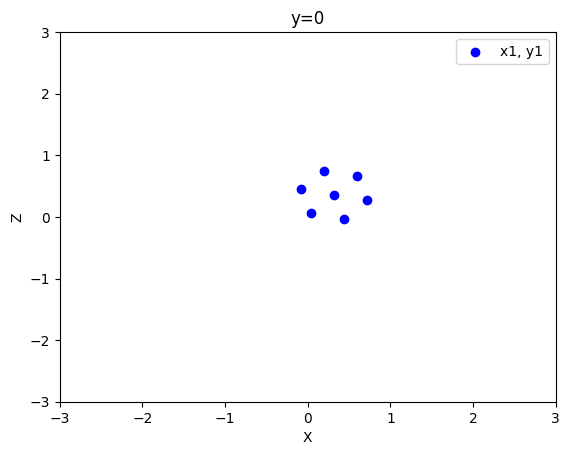

PointCloud with 14680 points.

In [289]:
Rokkaku = Hexagon(plot,pcd_r)
taikou_pcd = Rokkakuchu(Rokkaku,pcd_r)
Plot(Rokkaku)
taikou_pcd

## 六角柱内の点群の内，y座標の大きい順にH個選択

In [290]:
def Taikou(taikou_pcd):
    taikou_np = np.asarray(taikou_pcd.points)
    taikou_kouho = np.zeros((len(taikou_np),1),dtype=np.float32)
    taikou_kouho = taikou_np[:,1]
    taikou_kouho = sorted(taikou_kouho)
    taikou_sentaku = np.zeros((math.floor(len(taikou_np)/100)+3,1),dtype=np.float32)
    #y座標の上から座標内の点数/10だけの点を取り，平均を算出
    for T in range(math.floor(-len(taikou_np)/100),-1):
        taikou_sentaku[-T] = taikou_kouho[T]
    taikou_sentaku = taikou_sentaku[taikou_sentaku > 0]
    taikou = taikou_sentaku.mean()
    print(taikou_sentaku)
    print(f"この和牛の体高は{taikou}mです")

## y座標の平均を計算

In [291]:
Taikou(taikou_pcd)

[1.3285208 1.3281733 1.3279464 1.3278598 1.3265172 1.3262409 1.3259474
 1.3244565 1.3237898 1.3235998 1.3234386 1.3228288 1.3225907 1.3225658
 1.3223561 1.3221074 1.3218124 1.321214  1.320232  1.3200551 1.3200188
 1.3198732 1.3197232 1.3195027 1.3194873 1.3194453 1.3188475 1.3186297
 1.3175026 1.3174171 1.3173376 1.3172504 1.3171861 1.3169466 1.3167883
 1.3161315 1.3160784 1.3158381 1.3158339 1.3157904 1.3156617 1.3156476
 1.3150184 1.3150033 1.314625  1.3144891 1.3141263 1.3141019 1.3136706
 1.3133507 1.3132992 1.3131105 1.3130541 1.3128986 1.3126488 1.3125591
 1.3125434 1.3125259 1.3125057 1.3122845 1.3122051 1.3121464 1.3120576
 1.3119864 1.311828  1.3116597 1.3115999 1.3114712 1.3114709 1.3113146
 1.3112456 1.3110808 1.3108456 1.3108369 1.3106301 1.3102176 1.31009
 1.3098335 1.309618  1.3090612 1.3090335 1.3089069 1.3088883 1.3088518
 1.3087726 1.3085152 1.3083705 1.3083562 1.3083556 1.308066  1.3077948
 1.3077816 1.3072536 1.3071164 1.3069465 1.306941  1.3065368 1.3065258
 1.30639

## 体高推定完了